## This file visualize the results, calculate dice, etc.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import argparse
import SimpleITK as sitk
import scipy.ndimage
import scipy.stats
import imageio

In [26]:
# choose the input directoy, the image to visualize
input_dir = '/raid/COVID-19/lung_seg_em/output/medseg/'
mrn = 1
ct = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(input_dir, 'ct_origin', str(mrn)+'.nii.gz')))

In [27]:
# choose the slice to display. You don't need to rerun the previous cell if visualization mrn does not change
display_slice = 8

In [29]:
# load the results
data = dict(np.load(os.path.join(input_dir, 'npzs/0.npz')))
data['infection'] = np.load(os.path.join(input_dir, 'npzs/unet1/0.npy'))
data['consolidation'] = np.load(os.path.join(input_dir, 'npzs/unet2/0.npy'))

In [30]:
# discretize the predictions
pred = np.where(data['infection'] > 0.5, 1, 0)
pred[data['consolidation'] > 0.5] = 2
data['pred'] = pred

# thresholding method
th = (1024 - 200) / 110.0
pred_th = np.where(data['infection'] > 0.5, 1, 0)
con_th = np.where(data['img'][..., [3]] > th, 1, 0) * pred_th
pred_th[con_th == 1] = 2
data['pred_th'] = pred_th

In [31]:
def hard_dice(img, label):
    return 2 * np.sum(img * label, dtype = np.float32) / (np.sum(img) + np.sum(label) + 1e-4)

In [32]:
# calculate the dice coefficient
dice_total = hard_dice(np.where(data['pred'] > 0, 1, 0), np.where(data['label'] > 0, 1, 0))
dice_consolidation = hard_dice(np.where(data['pred'] == 2, 1, 0), np.where(data['label'] == 2, 1, 0))
dice_consolidation_th = hard_dice(np.where(data['pred_th'] == 2, 1, 0), np.where(data['label'] == 2, 1, 0))
print ('Total Dice: ', dice_total)
print ('Consolidation Dice: ', dice_consolidation)
print ('Consolidation Dice (threshold): ', dice_consolidation_th)

Total Dice:  0.6490222318950948
Consolidation Dice:  0.6279288341256649
Consolidation Dice (threshold):  0.5303186012700765


In [33]:
# dialte the labels and see how the specificity changes
# This figure shows that unet2's overestimation comes from border errors, i.e. the border enlarged a little bit compared to label
# However, thresholding's overestimation comes from misclassification of the vessels, which are far from the labels
specificity_list = []
specificity_th_list = []
mask = np.where(data['label'] > 0, 1, 0)
label = np.where(data['label'] == 2, 1, 0)
pred = np.where(data['pred'] == 2, 1, 0) 
pred_th = np.where(data['pred_th'] == 2, 1, 0)

for drate in range(10):
    print (drate, end=',')
    
    label_dilated = []
    for label_slice in label:
        if drate == 0:
            label_dilated.append(label_slice[...,0])
        else:
            label_dilated.append(scipy.ndimage.morphology.binary_dilation(label_slice[...,0], iterations=drate))
    label_dilated = np.array(label_dilated)[..., np.newaxis]
    
    specificity = np.sum(mask * (1 - pred) * (1 - label_dilated), dtype=np.float32) / np.sum(mask - mask * label_dilated)
    specificity_th = np.sum(mask * (1 - pred_th) * (1 - label_dilated), dtype=np.float32) / np.sum(mask - mask * label_dilated)
    specificity_list.append(specificity)
    specificity_th_list.append(specificity_th)

0,1,2,3,4,5,6,7,8,9,

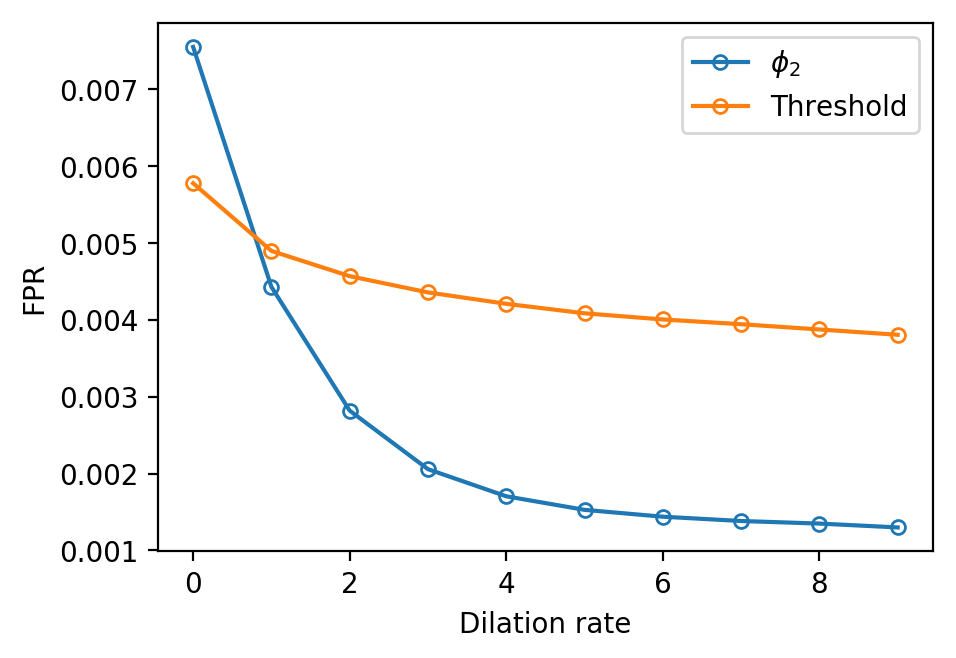

In [34]:
plt.figure(figsize=[5,3.5], dpi=200)
plt.plot(range(10), 1 - np.array(specificity_list), 'o-', markersize=5, fillstyle='none')
plt.plot(range(10), 1 - np.array(specificity_th_list), 'o-', markersize=5, fillstyle='none')
plt.xlabel('Dilation rate')
plt.ylabel('FPR')
plt.legend(['$\phi_2$', 'Threshold'])

In [82]:
def blend_ct_slice(islice, mrn, ct, pred, mrn_list, islice_list):
    # the ct image
    ct_slice = ct[islice, ::-1, :][..., np.newaxis]
    ct_slice = (ct_slice + 1150) / 1500.0 * 255
    ct_slice[ct_slice < 0] = 0
    ct_slice[ct_slice > 255] = 255
    ct_slice = np.tile(ct_slice, [1,1,3])
    
    # select the pred slice
    islice_sub = islice_list[mrn_list == mrn]
    offset = islice_sub.min() + 3
    seg_slice = islice - offset
    pred_slice = pred[(mrn_list == mrn) & (islice_list == seg_slice)]
    # return only ct image if islice not in the prediction slices
    if len(pred_slice) == 0:
        return ct_slice.astype(np.uint8)
   
    # zoom to ct image size
    pred_slice = scipy.ndimage.zoom(pred_slice[0, ::-1, :, 0], [2,2], order=0)        
    # blend
    consolidation = np.where(pred_slice == 2, 1, 0)
    consolidation_edge = consolidation - scipy.ndimage.morphology.binary_erosion(consolidation, iterations=2)
    infection = np.where(pred_slice > 0, 1, 0)
    infection_edge = infection - scipy.ndimage.morphology.binary_erosion(infection, iterations=2)
    infection_edge[consolidation == 1] = 0  # consolidation edge will override infection edge
    all_edge = infection_edge + consolidation_edge
    ct_slice[all_edge > 0, :] = 0
    ct_slice[consolidation_edge > 0, 0] = 255
    ct_slice[infection_edge > 0, 1] = 255
    
    return ct_slice.astype(np.uint8)

In [88]:
# CT image visualization
ct_label = blend_ct_slice(display_slice, str(mrn), ct, data['label'], data['mrn'].astype(str), data['islice'])
ct_pred_th = blend_ct_slice(display_slice, str(mrn), ct, data['pred_th'], data['mrn'].astype(str), data['islice'])
ct_pred = blend_ct_slice(display_slice, str(mrn), ct, data['pred'], data['mrn'].astype(str), data['islice'])

MRN = 1, slice = 8


Text(0.5,1,'EM')

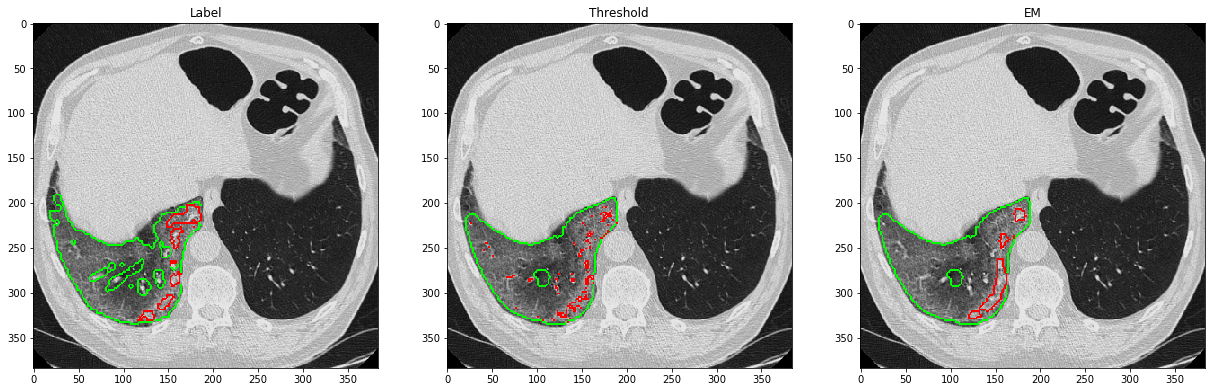

In [89]:
print ('MRN = %d, slice = %d'%(mrn, display_slice))
plt.figure(figsize=[21,7])
plt.subplot(131); plt.imshow(ct_label[64:-64, 64:-64]); plt.title('Label')
plt.subplot(132); plt.imshow(ct_pred_th[64:-64, 64:-64]); plt.title('Threshold')
plt.subplot(133); plt.imshow(ct_pred[64:-64, 64:-64]); plt.title('EM')